In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import matplotlib as mpl
from matplotlib import pyplot as pl
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

mplparams = {
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': False, # add a grid
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 14,
      'legend.fontsize': 'medium',
      'legend.frameon': False,
      'axes.formatter.limits': (-3,4)}

mpl.rcParams.update(mplparams)

In [3]:
import numpy as np

In [4]:
import matplotlib.gridspec as gridspec

Copy (and slightly change) the 2D greedy kde contour plotting from [plotutils](http://farr.github.io/plotutils/_modules/plotutils/plotutils.html#plot_greedy_kde_interval_2d) - Copyright: Will Farr @farr

In [5]:
import scipy.stats as ss

In [14]:
class newcorner:
    """
    Define class to plot the new corner plot style
    """
    def __init__(self, data, bins=None, ratio=3, labels=None, truths=None, legend=None, showlims=False, limlinestyle='dotted', showpoints=True, showcontours=False, hist_kwargs={}, scatter_kwargs={}, contour_kwargs={}, contour_levels=(0.5, 0.9, 0.95), use_math_text=True, figsize=(7,7)):
        # get number of dimensions in the data
        self.ndims = data.shape[1] # get number of dimensions in data
        self.ratio = ratio
        self.labels = labels
        self.truths = truths                 # true values for each parameter in data 
        if self.truths != None:
            if len(self.truths) != self.ndims: # must be same number of true values as parameters
                self.truths = None
        self.levels = contour_levels
        self.showpoints = showpoints
        self.showcontours = showcontours
        self.scatter_kwargs = scatter_kwargs
        self.contour_kwargs = contour_kwargs
        self.legend_labels = []
        self.use_math_text = use_math_text
        
        # set default hist_kwargs
        self.hist_kwargs = {'bins': 20, 'histtype': 'stepfilled', 'color': 'lightslategrey', 'alpha': 0.4, 'edgecolor': 'lightslategray', 'linewidth': 1.5}
        for key in hist_kwargs.keys(): # set any values input
            self.hist_kwargs[key] = hist_kwargs[key]

        if bins != None:
            if isinstance(bins, int) and bins > 0:
                self.hist_kwargs['bins'] = bins

        # create figure
        self.fig = pl.figure(figsize=figsize)
        self.histhori = []
        self.histvert = []
        self.jointaxes = []
        
        # create grid
        gridsize = self.ratio*(self.ndims-1) + 1
        gs = gridspec.GridSpec(gridsize, gridsize, wspace=0.1, hspace=0.1)

        # empty axes to hold any legend information
        self.legendaxis = self.fig.add_subplot(gs[0:ratio,((self.ndims-2)*ratio+1):(1+(self.ndims-1)*ratio)])
        for loc in ['top', 'right', 'left', 'bottom']:
            self.legendaxis.spines[loc].set_visible(False) # remove borders
        pl.setp(self.legendaxis.get_xticklabels(), visible=False) # remove xtick labels
        pl.setp(self.legendaxis.get_yticklabels(), visible=False) # remove ytick labels
        self.legendaxis.tick_params(bottom='off', top='off', left='off', right='off') # remove tick marks
        
        # create figure axes
        for i in range(ndims-1):
            # vertical histogram (and empty axes)
            axv = self.fig.add_subplot(gs[i*ratio:(i+1)*ratio,0])
            if showlims:
                for loc in ['top', 'bottom']:
                    axv.spines[loc].set_alpha(0.2)
                    axv.spines[loc].set_linestyle(limlinestyle)
            else:
                axv.spines['top'].set_visible(False)    # remove top border
                axv.spines['bottom'].set_visible(False) # remove bottom border
            axv.spines['right'].set_visible(False)  # remove right border
            axv.set_xticklabels([])
            axv.set_xticks([])
            axv.yaxis.set_ticks_position('left') # just show ticks on left
            self.histvert.append(axv)
                
            # horizontal histograms
            axh = self.fig.add_subplot(gs[-1,(i*ratio+1):(1+(i+1)*ratio)])
            axh.spines['top'].set_visible(False)    # remove top border
            if showlims:
                for loc in ['left', 'right']:
                    axh.spines[loc].set_alpha(0.2)
                    axh.spines[loc].set_linestyle(limlinestyle)
            else:
                axh.spines['left'].set_visible(False)   # remove left border
                axh.spines['right'].set_visible(False)  # remove right border
            axh.set_yticklabels([])
            axh.set_yticks([])
            axh.xaxis.set_ticks_position('bottom') # just show ticks on left
            self.histhori.append(axh)
                
            # joint plots
            for j in range(i+1):
                axj = self.fig.add_subplot(gs[i*ratio:(i+1)*ratio,(j*ratio+1):(1+(j+1)*ratio)], sharey=self.histvert[i], sharex=self.histhori[j])
                if showlims:
                    for loc in ['top', 'right', 'left', 'bottom']:
                        axj.spines[loc].set_alpha(0.2) # show border, but with alpha = 0.2
                        axj.spines[loc].set_linestyle(limlinestyle)
                else:
                    for loc in ['top', 'right', 'left', 'bottom']:
                        axj.spines[loc].set_visible(False) # remove borders

                pl.setp(axj.get_xticklabels(), visible=False) # remove xtick labels
                pl.setp(axj.get_yticklabels(), visible=False) # remove ytick labels
                axj.tick_params(bottom='off', top='off', left='off', right='off') # remove tick marks 
                self.jointaxes.append(axj)
        
        # check for alpha of filled histogram plot
        if self.hist_kwargs['histtype'] == 'stepfilled':
            self._check_alpha()
        
        # create plots
        self._add_plots(data, label=legend)

    def add_data(self, data, hist_kwargs, legend=None, showpoints=True, showcontours=False, scatter_kwargs={}, contour_kwargs={}, contour_levels=(0.5, 0.9, 0.95)):
        """
        Add another data set to the plots, hist_kwargs are required.
        """

        ndims =  data.shape[1]

        if ndims != self.ndims:
            raise("Error... number of dimensions not the same")

        self.hist_kwargs = hist_kwargs
        if 'bins' not in self.hist_kwargs:
            # set default number of bins to 20
            hist_kwargs['bins'] = 20
        self.scatter_kwargs = scatter_kwargs
        self.levels = contour_levels
        self.showpoints = showpoints
        self.showcontours = showcontours
        self.contour_kwargs = contour_kwargs

        self._add_plots(data, label=legend)
        self._format_axes()

    def _add_plots(self, data, label=None):
        """
        Add histogram and joint plots to the figure using data
        
        Label is a legend label if required.
        """

        # the vertical histogram
        self.histvert[-1].hist(data[:,-1], normed=True, orientation='horizontal', label=label, **self.hist_kwargs)
        if self.truths != None:
            self.histvert[-1].axhline(self.truths[-1], color='k', ls='--', lw=1.5)

        # put legend in the upper right plot
        _, l1 = self.histvert[-1].get_legend_handles_labels()
        if self.legend_labels != None:
            if self.hist_kwargs['histtype'] == 'stepfilled':
                lc = self.hist_kwargs['edgecolor']
            else:
                lc = self.hist_kwargs['color']
            self.legend_labels.append(Line2D([], [], linewidth=self.hist_kwargs['linewidth'], color=lc)) # create fake line for legend (to use line rather than a box)
        self.legendaxis.legend(self.legend_labels, l1, loc='lower left')
        if self.labels != None:
            self.histvert[-1].set_ylabel(self.labels[-1])
        
        if self.showpoints:
            # set default scatter plot kwargs
            if 'color' in self.hist_kwargs:
                c = self.hist_kwargs['color']
            elif 'fc' in self.hist_kwargs and self.hist_kwargs['histtype'] == 'stepfilled':
                c = self.hist_kwargs['fc'][0:3]
            else:
                c = 'b'

            these_scatter_kwargs = {'c': c, 'marker': 'o', 's': 20, 'alpha': 0.05, 'edgecolors': 'none'}
            
            for key in self.scatter_kwargs.keys():
                these_scatter_kwargs[key] = self.scatter_kwargs[key]
            self.scatter_kwargs = these_scatter_kwargs
        
        if self.showcontours:
            # set default contour kwargs
            these_contour_kwargs = {'colors': 'k'}

            for key in self.contour_kwargs.keys():
                these_contour_kwargs[key] = self.contour_kwargs[key]
            self.contour_kwargs = these_contour_kwargs
        
        # the horizontal histograms and joint plots
        jointcount = 0
        rowcount = 0
        for i in range(self.ndims-1):
            self.histhori[i].hist(data[:,i], normed=True, **self.hist_kwargs)
            if self.labels != None:
                self.histhori[i].set_xlabel(self.labels[i])
            if self.truths != None:
                self.histhori[i].axvline(self.truths[i], color='k', ls='--', lw=1.5)

            for j in range(i+1):
                if labels != None:
                    if j == 0:
                        self.histvert[rowcount].set_ylabel(self.labels[i+1])
                        rowcount += 1
                
                if self.showpoints:
                    self.jointaxes[jointcount].scatter(data[:,j], data[:,i+1], **self.scatter_kwargs) # plot scatter
                
                if self.showcontours:
                    self.plot_2d_contours(self.jointaxes[jointcount], np.vstack((data[:,j], data[:,i+1])).T)

                if self.truths != None:
                    self.jointaxes[jointcount].plot(self.truths[j], self.truths[i+1], 'kx')

                jointcount += 1
    
    def _format_axes(self):
        """
        Set some formatting of the axes
        """
        pl.draw() # force labels to be drawn
        
        # move exponents into label
        for ax in self.histvert:
            #[l.set_rotation(45) for l in ax.get_yticklabels()]
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=self.use_math_text))
            self.format_exponents_in_label_single_ax(ax.yaxis)
            
        for ax in self.histhori:
            [l.set_rotation(45) for l in ax.get_xticklabels()]
            ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=self.use_math_text))
            self.format_exponents_in_label_single_ax(ax.xaxis)
        
        # remove any offset text from shared axes caused by the scalar formatter for MathText
        for ax in self.jointaxes:
            ax.xaxis.offsetText.set_visible(False)
            ax.yaxis.offsetText.set_visible(False)
    
    def plot_2d_contours(self, ax, pts, xmin=None, xmax=None, ymin=None, ymax=None, Nx=100, Ny=100):
        """
        Plots the given probability interval contours, using a greedy
        selection algorithm.

        The algorithm uses a two-step process (see `this document
        <https://dcc.ligo.org/LIGO-P1400054/public>`_) so that the
        resulting credible areas will be unbiased.

        :param ax: a matplotlib axis on which to plot the contours

        :param pts: Array of shape ``(Npts, 2)`` that contains the points
          in question.

        :param xmin: Minimum value in x.  If ``None``, use minimum data
          value.

        :param xmax: Maximum value in x.  If ``None``, use minimum data
          value.

        :param ymin: Minimum value in y.  If ``None``, use minimum data
          value.
    
        :param ymax: Maximum value in y.  If ``None``, use minimum data
          value.

        :param Nx: Number of subdivisions in x for contour plot.  (Default
          100.)

        :param Ny: Number of subdivisions in y for contour plot.  (Default
          100.)

        """

        Npts = pts.shape[0]
    
        kde_pts = pts[:Npts/2,:]
        den_pts = pts[Npts/2:,:]

        Nkde = kde_pts.shape[0]
        Nden = den_pts.shape[0]

        kde = ss.gaussian_kde(kde_pts.T)
        den = kde(den_pts.T)
        densort = np.sort(den)[::-1]

        if xmin is None:
            xmin = np.min(pts[:,0])
        if xmax is None:
            xmax = np.max(pts[:,0])
        if ymin is None:
            ymin = np.min(pts[:,1])
        if ymax is None:
            ymax = np.max(pts[:,1])

        xs = np.linspace(xmin, xmax, Nx)
        ys = np.linspace(ymin, ymax, Ny)

        XS, YS = np.meshgrid(xs,ys)
        ZS = np.reshape(kde(np.row_stack((XS.flatten(), YS.flatten()))), (Nx, Ny))

        zvalues=[]
        for level in self.levels:
            ilevel = int(Nden*level + 0.5)
            if ilevel >= Nden:
                ilevel = Nden-1
            zvalues.append(densort[ilevel])

        ax.contour(XS, YS, ZS, zvalues, **self.contour_kwargs)
    
    def _check_alpha(self):
        # use answer from http://stackoverflow.com/a/28398471/1862861 to have alpha transparency on hist patches, but not on edges
        if 'alpha' in self.hist_kwargs:
            alpha = self.hist_kwargs.pop('alpha')
            if 'color' in self.hist_kwargs:
                cl = self.hist_kwargs.pop('color')
            else:
                # default to blue if no color is given
                cl = 'blue'

            if not isinstance(cl, tuple):
                # import these to get RGB color codes for names colors
                from matplotlib import colors as cs

                if cl in cs.cnames:
                    rgbcolor = cs.hex2color(cs.cnames[cl])
                else:
                    print("histogram color '%s' not recognised. Defaulting to blue" % cl)
                    rgbcolor = cs.hex2color(cs.cnames['blue'])
                # add facecolor 'fc' to hist_kwargs
                ctup = rgbcolor + (alpha,)
            else:
                if len(cl) == 3:
                    ctup = cl + (alpha,)
                else:
                    ctup = cl

            # add tuple (r, g, b, alpha) facecolor 'fc' to hist_kwargs
            self.hist_kwargs['fc'] = ctup
            
    def update_label(self, old_label, exponent_text):
        """ Method to transform given label into the new label (by Greg Ashton) """
        if exponent_text == "":
            return old_label
        try:
            units = old_label[old_label.index("[") + 1:old_label.rindex("]")]
        except ValueError:
            units = ""

        label = old_label.replace("[{}]".format(units), "")
        exponent_text = exponent_text.replace("\\times", "")
        if units == "":
            s = r"{} [{}]".format(label, exponent_text)
        else:
            s = r"{} [{} {}]".format(label, exponent_text, units)
        #s = s.replace("-", "\\textrm{-}")
        return s

    def format_exponents_in_label_single_ax(self, ax):
        """ Routine for a single axes instance (by Greg Ashton) """

        exponent_text = ax.get_offset_text().get_text()
        exponent_text = exponent_text.replace("\\mathdefault", "")
        label = ax.get_label().get_text()
        ax.offsetText.set_visible(False)
        ax.set_label_text(self.update_label(label, exponent_text))
            
    def savefig(self, filename):
        self.fig.savefig(filename)

    def get_fig(self):
        return self.fig


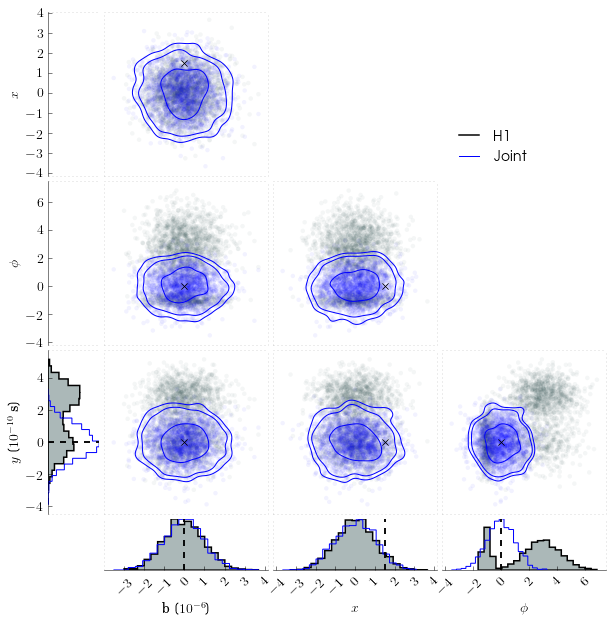

In [15]:
# number of parameters
ndims = 4

# ratio of joint plots to histogram plots
ratio = 3

x = np.zeros((2000,ndims))
x[:,0:2] = np.random.randn(2000,2)
x[0:500,2] = -1. + 0.25*np.random.randn(500)
x[500:2000,2] = 3. + 1.25*np.random.randn(1500)
x[0:1000, 3] = 1.*np.random.randn(1000)
x[1000:2000, 3] = 3.+0.75*np.random.randn(1000)
x[:,0] = x[:,0]*1e-6
x[:,3] = x[:,3]*1e-10
#x = np.random.randn(1000, ndims)

showlims = True

labels = ['$\\textrm{b}$', '$x$', '$\phi$', '$y$ [$\\textrm{s}$]']

#histops = {'histtype': 'stepfilled', 'color': 'firebrick', 'edgecolor': 'firebrick', 'linewidth': 1.5, 'alpha': 0.2}
histops = {'histtype': 'stepfilled', 'color': 'darkslategrey', 'edgecolor': 'black', 'linewidth': 1.5}

# create plot
p = newcorner(x, labels=labels, truths=[0., 1.52, 0., 0.], showlims=showlims, hist_kwargs=histops, legend='H1', figsize=(10,10))

z = np.random.randn(2000,ndims)
z[:,0] = z[:,0]*1e-6
z[:,3] = z[:,3]*1e-10
p.add_data(z, {'histtype': 'step', 'color': 'blue', 'linewidth': 1}, legend='Joint', showcontours=True, contour_kwargs={'colors': 'blue'})